# Recommender library competition 
## By Amélie Madrona & Linne Verhoeven
Link to the [kaggle competition](https://www.kaggle.com/competitions/library-recommender-competition/overview)

Goal:
* Train recommender system on training interactions data
* Generate recommendations for each user ID in the dataset. 
* Provide the top 10 recommendations of your model for each user
* Make sure that your submission file has the same format as the sample_submission.csv file in the Data tab (i.e. separated by a space)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
interactions = pd.read_csv('data/interactions_train.csv')
print(interactions.shape)
interactions['t'] = pd.to_datetime(interactions['t'], unit='s')
interactions.head()

(87047, 3)


,u,i,t
0,4456,8581,2023-06-23 17:24:46
1,142,1964,2023-03-23 15:30:06
2,362,3705,2024-02-02 11:00:59
3,1809,11317,2023-01-12 14:19:22
4,4384,1323,2023-04-13 16:09:22


In [12]:
items = pd.read_csv('data/items.csv')
print(items.shape)
items.head()

(15291, 6)


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [13]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()


(7838, 2)


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [14]:
n_users = interactions.u.nunique()
n_items = interactions.i.nunique()
print(f'Number of users = {n_users}, \nNumber of movies = {n_items} \nNumber of interactions = {len(interactions)}')
# So the sample submission is the top x items for each user
# And we have info for all the books in items

Number of users = 7838, 
Number of movies = 15109 
Number of interactions = 87047


In [15]:
# TODO: EDA on the interactions data and the items metadata. 

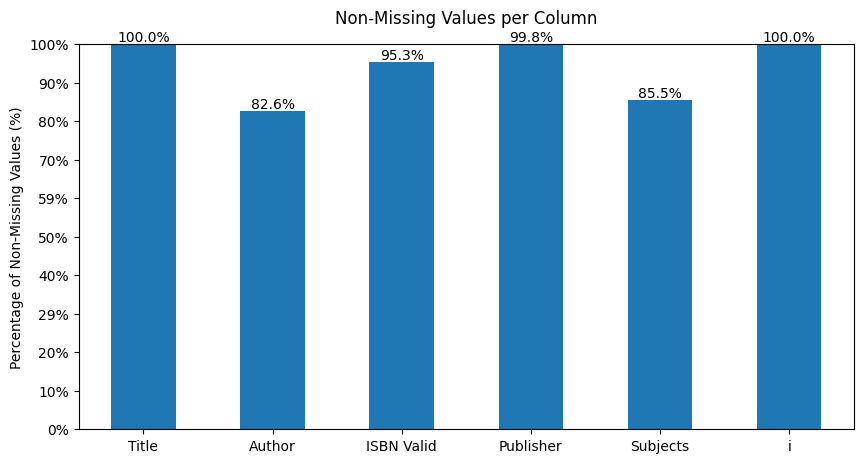

In [23]:
items.notna().sum().plot(kind='bar', figsize=(10, 5), title='Non-Missing Values per Column')
plt.ylabel('Percentage of Non-Missing Values (%)')
total_rows = len(items)
for p in plt.gca().patches:
    percentage = 100 * p.get_height() / total_rows
    plt.gca().annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=10)
plt.ylim(0, total_rows)
plt.title('Non-Missing Values per Column', pad=15)
plt.yticks(np.linspace(0, total_rows, 11), [f'{int(100*x/total_rows)}%' for x in np.linspace(0, total_rows, 11)])
plt.xticks(rotation=0)
plt.show()

In [25]:
import spacy

# Load spaCy models
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")

def clean_text_multilang(text):
    docs = [nlp_en(text), nlp_fr(text), nlp_de(text)]
    
    # Get intersection of stopwords across languages
    all_stopwords = set()
    for doc in docs:
        all_stopwords.update([token.text.lower() for token in doc if token.is_stop])

    # Remove punctuation and stopwords
    cleaned_tokens = [
        token.text.lower()
        for token in nlp_en(text)  # Use English tokenizer (works well enough across languages)
        if token.is_alpha and token.text.lower() not in all_stopwords
    ]
    return " ".join(cleaned_tokens)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject